# Robbery_GradCAM

## 1. Dataset

In [1]:
import zipfile

In [2]:
zip_file_path = '/content/drive/MyDrive/Dataset/Robbery_Accident_Fire_Database.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

## 2. Datablock

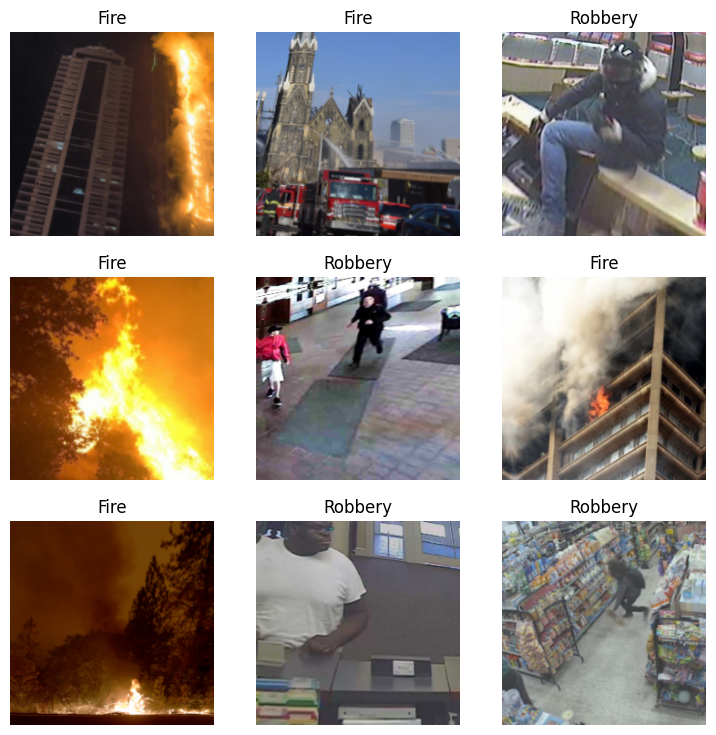

In [3]:
from fastai.vision.all import *

path = 'Robbery_Accident_Fire_Database2'

# DataBlock 정의
block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # 입력 및 출력 유형
    get_items=get_image_files,  # 이미지 파일을 가져오는 함수
    get_y=parent_label,  # 상위 폴더를 레이블로 사용

    splitter = RandomSplitter(seed=2024),  # 무작위 분할
    item_tfms=Resize(224),  # 모든 이미지를 224x224로 크기 조정
    batch_tfms=aug_transforms()  # 데이터 증가 (옵션)
)

# DataLoader 생성
loader = block.dataloaders(path)

# 배치 시각화
loader.show_batch()

## 3. Pre_Training_Model : ResNet-18

FastAI 라이브러리에서 제공되는 사전 훈련된 ResNet-18 모델입니다.

ResNet-18은 이미지 분류 및 관련 작업에 널리 사용되는 컨볼루션 신경망 아키텍처 중 하나로 해당 모델을 활용하여 학습을 진행합니다.

In [15]:
learn = vision_learner(loader, resnet18, metrics=accuracy)
learn.fine_tune(epochs = 10)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes sh

## 4. TEST

학습한 결과를 출력하며 두개의 레이블 중 상단에 있는 문구가 학습모델에 대한 정답을 가리킵니다.

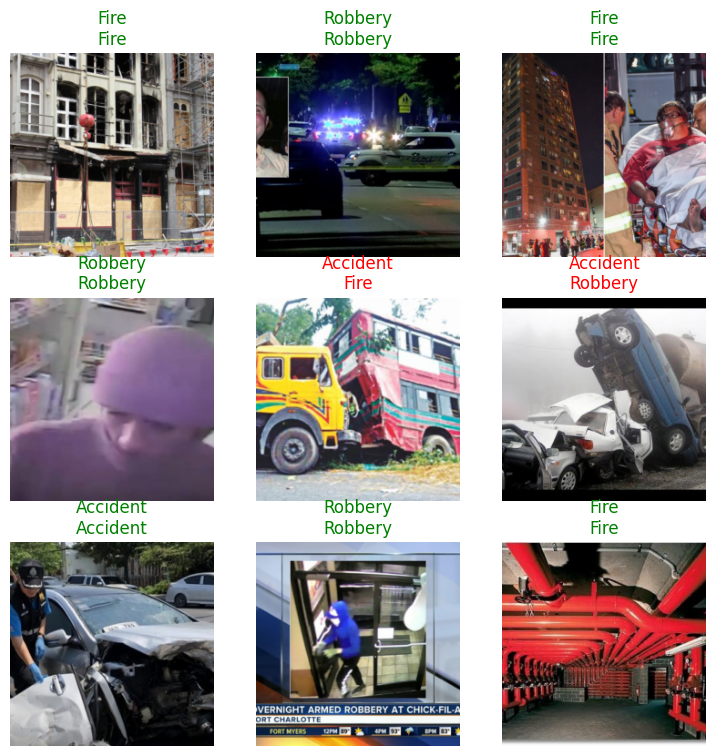

In [16]:
# test result
learn.show_results() # 위에가 정답

## 5. visualization(시각화)

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])


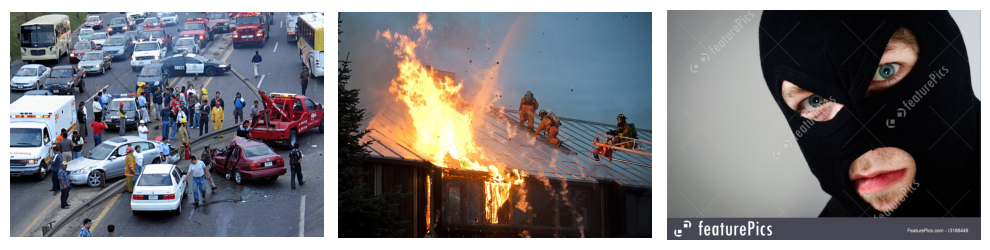

In [17]:
# GradCAM
Accident_path = '/content/Robbery_Accident_Fire_Database2/Accident/0.jpg'
Fire_path = '/content/Robbery_Accident_Fire_Database2/Fire/0.jpg'
Robbery_path = "/content/Robbery_Accident_Fire_Database2/Robbery/0.jpg"

test_loader = loader.test_dl([Accident_path, Fire_path, Robbery_path]) # 전처리

acc_x, fire_x, rob_x = next(iter(test_loader))[0]

acc_x = acc_x.unsqueeze(0)
fire_x = fire_x.unsqueeze(0)
rob_x = rob_x.unsqueeze(0)

print(acc_x.shape, fire_x.shape, rob_x.shape)

acc_img = Image.open(Accident_path)
fire_img = Image.open(Fire_path)
rob_img = Image.open(Robbery_path)

fig, ax = plt.subplots(1, 3, figsize=(10, 8))
ax[0].imshow(acc_img)
ax[0].axis('off')
ax[1].imshow(fire_img)
ax[1].axis('off')
ax[2].imshow(rob_img)
ax[2].axis('off')
plt.tight_layout()
plt.show()

## 6. Grad CAM

PyTorch에서 사용되는 Hook 클래스를 정의합니다.

Hook는 모델의 특정 레이어의 출력 또는 역전파 그라디언트를 추출하기 위해 사용되며 구성은 아래와 같습니다.

In [18]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self, m, i, o):
        self.stored = o.detach().clone()
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        self.hook.remove()

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)
    def hook_func(self, m, gi, go):
        self.stored = go[0].detach().clone()
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        self.hook.remove()

이 코드는 PyTorch를 사용하여 Grad-CAM(Gradient-weighted Class Activation Mapping)을 계산하는 함수를 정의합니다.

GradCAM heatmap이 시각화됩니다. 이 heatmap은 모델이 예측을 하기 위해 어떤 부분을 중요하게 고려했는지를 시각적으로 보여줍니다.

In [19]:
def get_gradcam(x, location=-1): # 어느 레이어에서 뽑아낼껀지
    with HookBwd(learn.model[0][location]) as hookg:
        with Hook(learn.model[0][location]) as hook:
            output = learn.model.eval()(x.cuda())
            idx = torch.argmax(output)
            act = hook.stored
        output[0, idx].backward()
        grad = hookg.stored

    w = grad[0].mean(dim=[1, 2], keepdim=True)
    heatmap = (w * act[0]).sum(0).detach().cpu()

    return heatmap

Input 이미지의 카테고리 순서에 따라 GradCAM 히트맵을 시각화합니다.

(-0.5, 13.5, 13.5, -0.5)

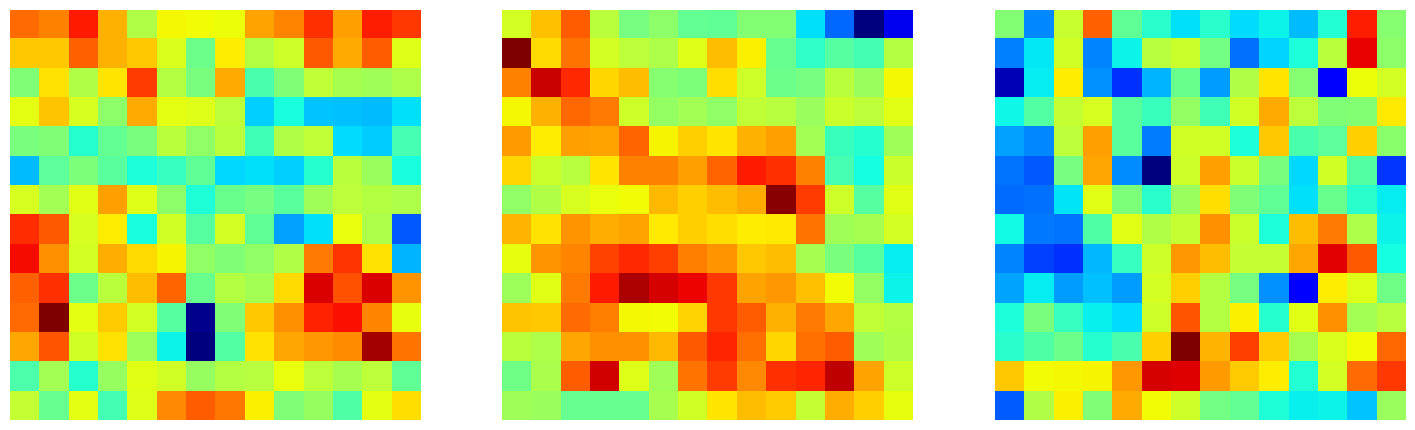

In [20]:
acc_heatmap = get_gradcam(acc_x,location=-2)
fire_heatmap = get_gradcam(fire_x, location=-2)
rob_heatmap = get_gradcam(rob_x, location=-2)

# 히트맵 이미지 표시
fig, ax = plt.subplots(1, 3, figsize=(18, 6))


ax[0].imshow(acc_heatmap, cmap='jet')
ax[0].axis('off')
ax[1].imshow(fire_heatmap, cmap='jet')
ax[1].axis('off')
ax[2].imshow(rob_heatmap, cmap='jet')
ax[2].axis('off')

## Result

첫 번째 서브플롯에는 원본 이미지를 표시하고,

두 번째 서브플롯에는 원본 이미지 위에 GradCAM heatmap을 덧붙여 모델의 인식성능 테스트를 시각화합니다.

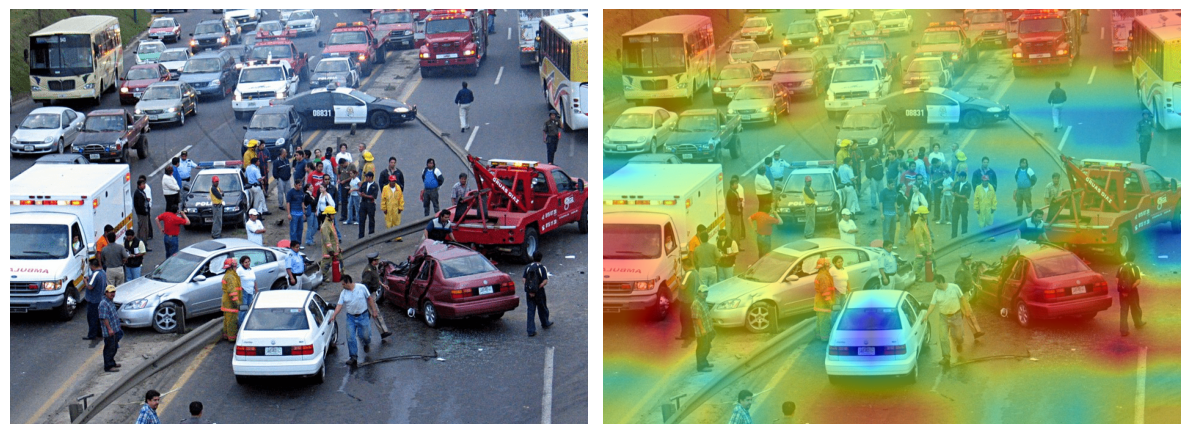

In [21]:
img = Image.open(Accident_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(img)
ax[1].imshow(acc_heatmap.cpu(), alpha=0.5, extent=(0, img.width, img.height, 0),
              interpolation='bilinear', cmap='jet')
ax[1].axis('off')
plt.tight_layout()
plt.show()

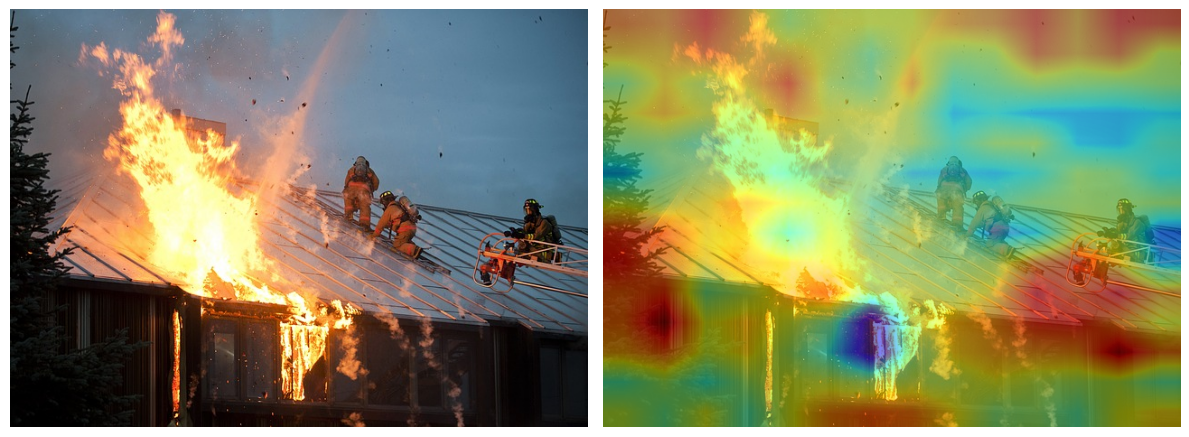

In [22]:
img = Image.open(Fire_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(img)
ax[1].imshow(acc_heatmap.cpu(), alpha=0.5, extent=(0, img.width, img.height, 0),
              interpolation='bilinear', cmap='jet')
ax[1].axis('off')
plt.tight_layout()
plt.show()

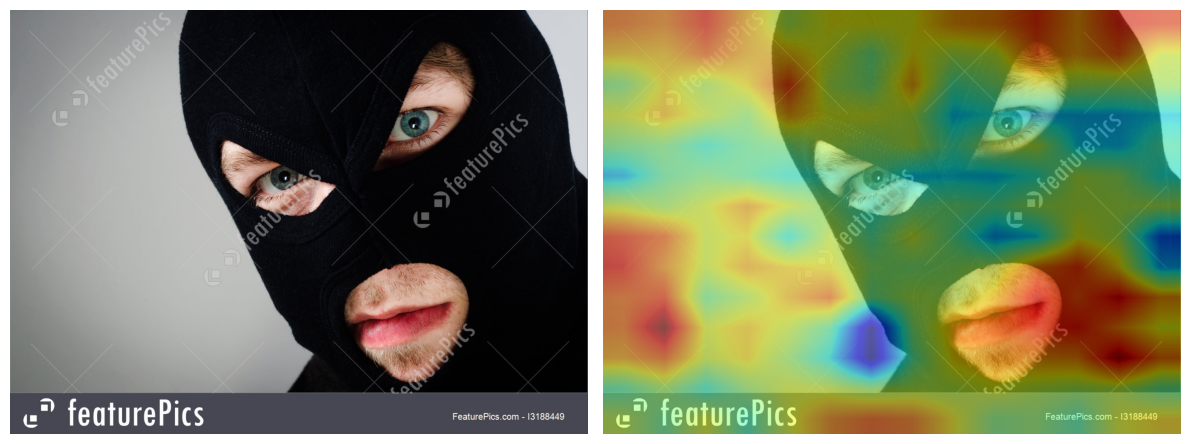

In [23]:
img = Image.open(Robbery_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(img)
ax[1].imshow(acc_heatmap.cpu(), alpha=0.5, extent=(0, img.width, img.height, 0),
              interpolation='bilinear', cmap='jet')
ax[1].axis('off')
plt.tight_layout()
plt.show()